In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torchvision, torch
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
import torch, torch.nn
import pickle
import pandas as pd
import shutil
import json
import glob
import seaborn
import scipy
import gzip

In [2]:
def full_frame(width=None, height=None):
    import matplotlib as mpl
    mpl.rcParams['savefig.pad_inches'] = 0
    figsize = None if width is None else (width, height)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)

In [3]:
with gzip.open("trial_record.json.gz", 'r') as fin: 
    record = json.load(fin)

In [4]:
df = pd.DataFrame(record)
df.index += 1 
df.head()

,id,idx,dataset,source,target,label,model_used,pred,attribs,trialid,trial
1,NIH_Dataset-4069616990-Cardiomegaly-1,40696,NIH_Dataset,"{'index': 68896, 'Image Index': '00016990_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.638716,{'image': 'images/NIH_Dataset-4069616990-Cardi...,1,0
2,NIH_Dataset-5015520986-Cardiomegaly-1,50155,NIH_Dataset,"{'index': 85137, 'Image Index': '00020986_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.610710,{'image': 'images/NIH_Dataset-5015520986-Cardi...,2,0
3,NIH_Dataset-6417228873-Cardiomegaly-1,64172,NIH_Dataset,"{'index': 106971, 'Image Index': '00028873_009...",Cardiomegaly,1,XRV-DenseNet121-all,0.685441,{'image': 'images/NIH_Dataset-6417228873-Cardi...,3,0
4,NIH_Dataset-638248-Cardiomegaly-0,638,NIH_Dataset,"{'index': 1025, 'Image Index': '00000248_022.p...",Cardiomegaly,0,XRV-DenseNet121-all,0.605365,{'image': 'images/NIH_Dataset-638248-Cardiomeg...,4,0
5,NIH_Dataset-108404381-Cardiomegaly-1,10840,NIH_Dataset,"{'index': 16454, 'Image Index': '00004381_021....",Cardiomegaly,1,XRV-DenseNet121-all,0.636316,{'image': 'images/NIH_Dataset-108404381-Cardio...,5,0


In [5]:
reads =  [['reader-results/read0-reader1.csv',0, 1],
         [ 'reader-results/read1-reader1.csv',1, 1],
         [ 'reader-results/read0-reader2.csv',0, 2],
         [ 'reader-results/read1-reader2.csv',1, 2]]

In [6]:
results_list = []
for fname, read, reader in reads:
    results = pd.read_csv(fname)
    results["read"] = read
    results["reader"] = reader
    results_list.append(results.set_index("Example"))

In [7]:
results = pd.concat(results_list)

In [8]:
results

,How confident are you in the models prediction? (1-5),Is the model looking at the correct feature? (1-5),read,reader
Example,,,,
1,4,3,0,1
2,4,3,0,1
3,5,4,0,1
4,3,2,0,1
5,5,3,0,1
...,...,...,...,...
236,1,1,1,2
237,1,1,1,2
238,1,1,1,2


In [9]:
results.columns = ["confident","features", "read", "reader"]

In [10]:
dd = df.join(results)
dd.head()

,id,idx,dataset,source,target,label,model_used,pred,attribs,trialid,trial,confident,features,read,reader
1,NIH_Dataset-4069616990-Cardiomegaly-1,40696,NIH_Dataset,"{'index': 68896, 'Image Index': '00016990_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.638716,{'image': 'images/NIH_Dataset-4069616990-Cardi...,1,0,4,3,0,1
1,NIH_Dataset-4069616990-Cardiomegaly-1,40696,NIH_Dataset,"{'index': 68896, 'Image Index': '00016990_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.638716,{'image': 'images/NIH_Dataset-4069616990-Cardi...,1,0,4,5,1,1
1,NIH_Dataset-4069616990-Cardiomegaly-1,40696,NIH_Dataset,"{'index': 68896, 'Image Index': '00016990_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.638716,{'image': 'images/NIH_Dataset-4069616990-Cardi...,1,0,4,4,0,2
1,NIH_Dataset-4069616990-Cardiomegaly-1,40696,NIH_Dataset,"{'index': 68896, 'Image Index': '00016990_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.638716,{'image': 'images/NIH_Dataset-4069616990-Cardi...,1,0,5,5,1,2
2,NIH_Dataset-5015520986-Cardiomegaly-1,50155,NIH_Dataset,"{'index': 85137, 'Image Index': '00020986_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.610710,{'image': 'images/NIH_Dataset-5015520986-Cardi...,2,0,4,3,0,1


In [11]:
dd.to_csv("trial_results.csv", index=False)

In [12]:
dd = pd.read_csv("trial_results.csv")

In [13]:
# adjust for second read
dd["trial"][dd["read"] == 1] = np.abs(dd["trial"][dd["read"] == 1]-1)

In [14]:
dd["label"][dd.label == 0] = "False Positive"
dd["label"][dd.label == 1] = "True Positive"
dd["trial"][dd.trial == 0] = "Traditional"
dd["trial"][dd.trial == 1] = "Counterfactual"

In [15]:
dd['confident'] = dd.confident.astype(float)

In [224]:
np.arange(0.5,6.1,1)

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])

Atelectasis 0.225 WilcoxonResult(statistic=33.0, pvalue=0.11168946794685176)
Cardiomegaly 0.275 WilcoxonResult(statistic=16.0, pvalue=0.0045086983649042355)
Effusion -0.025 WilcoxonResult(statistic=23.5, pvalue=0.6657709231765883)
Lung Opacity 0.175 WilcoxonResult(statistic=13.0, pvalue=0.2435897094939673)
Mass 0.25 WilcoxonResult(statistic=32.0, pvalue=0.18413837674091527)
Pneumothorax 0.0 WilcoxonResult(statistic=108.0, pvalue=0.7892680261342813)
Atelectasis -0.025 WilcoxonResult(statistic=148.0, pvalue=0.9526195021391685)
Cardiomegaly 0.3 WilcoxonResult(statistic=17.0, pvalue=0.0026997960632601866)
Effusion 0.0 WilcoxonResult(statistic=88.0, pvalue=0.7672536055754013)
Lung Opacity 0.075 WilcoxonResult(statistic=22.5, pvalue=0.6043691328898215)
Mass -0.15 WilcoxonResult(statistic=124.5, pvalue=0.4458055610443783)
Pneumothorax 0.075 WilcoxonResult(statistic=63.0, pvalue=0.7916520159959579)


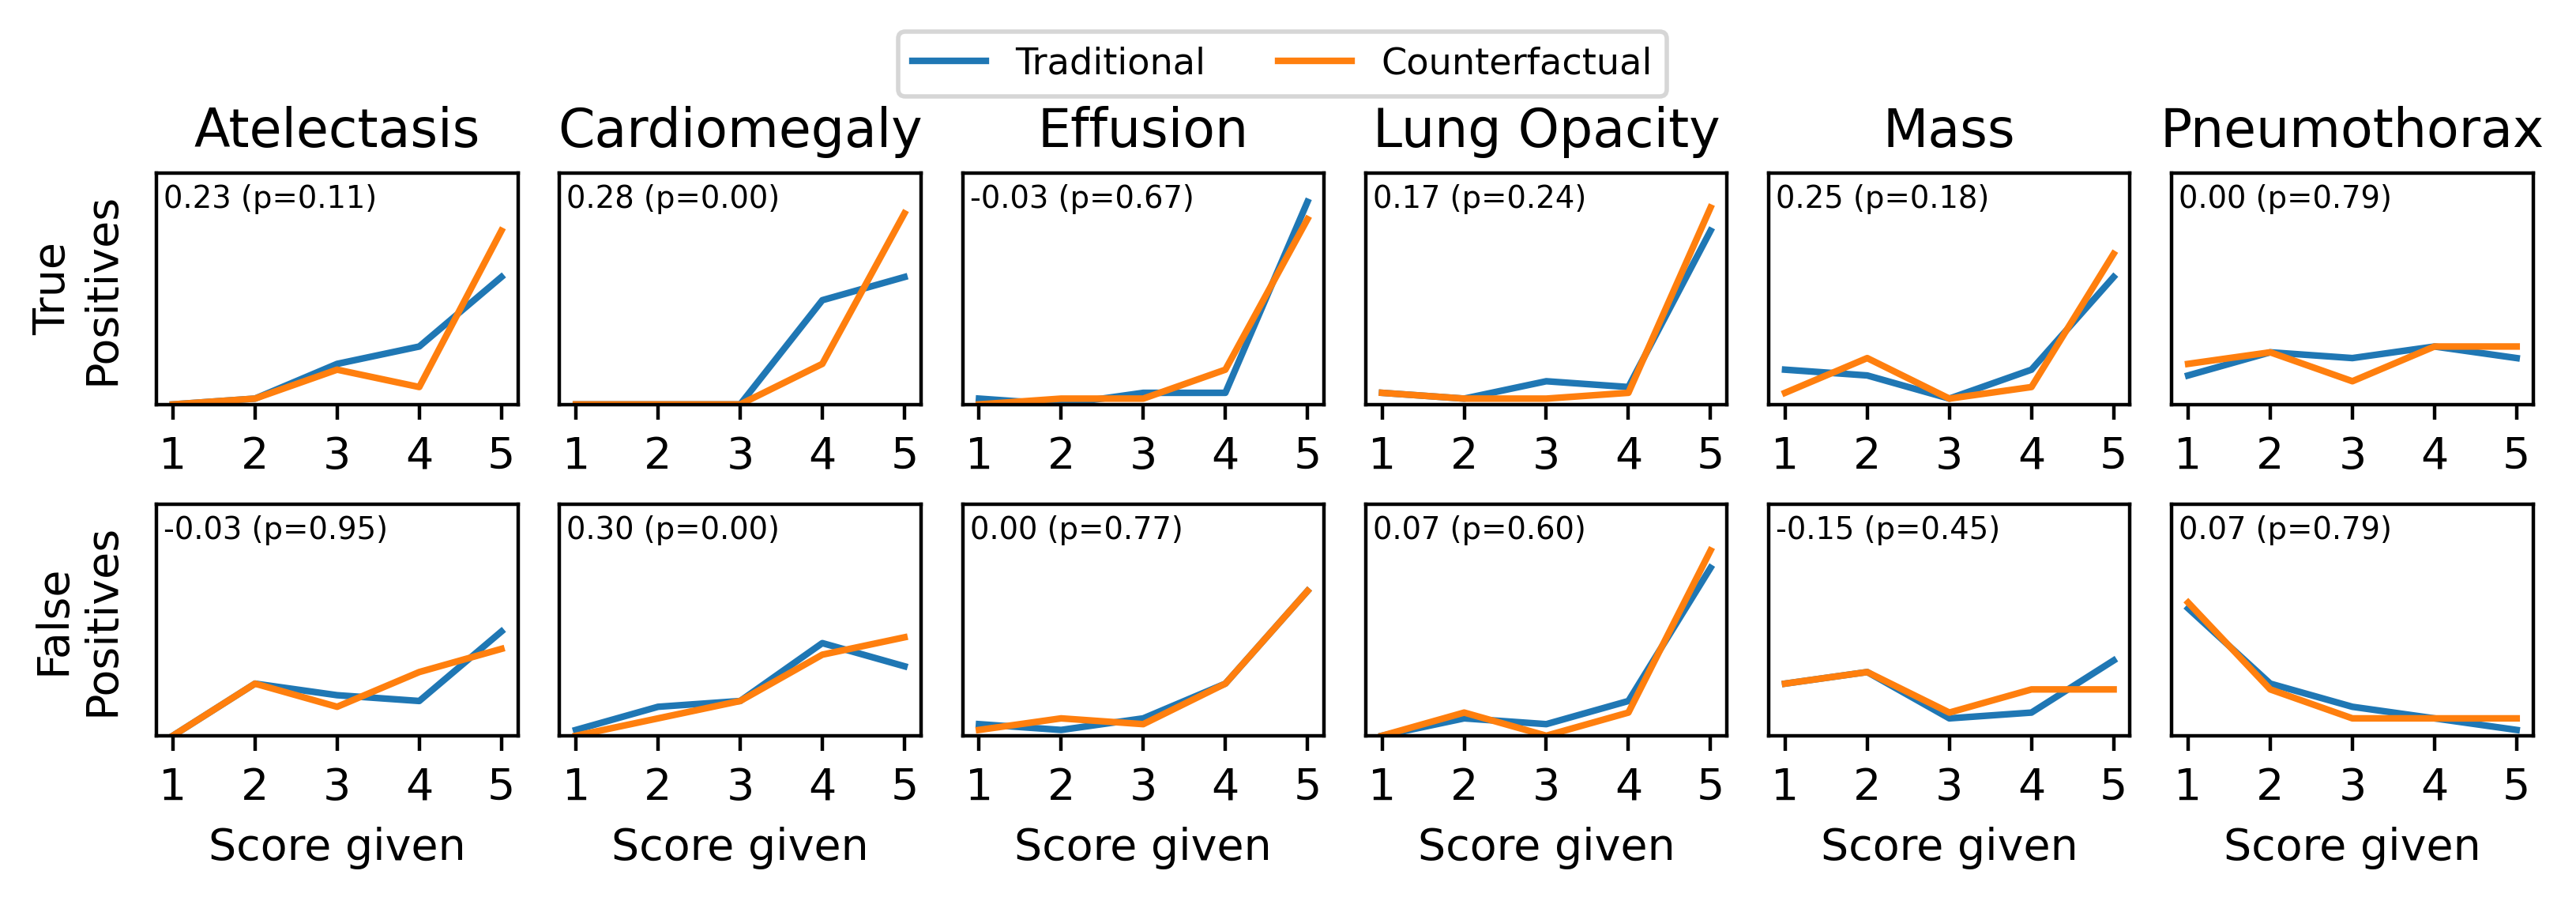

In [233]:
ylim = 0,1
num_participants = 40
bins = np.arange(0.5,6.1,1)
fig, ax = plt.subplots(2,len(dd["target"].unique()), figsize=(8,2.5), dpi=400, constrained_layout=True, facecolor='w')
for i, (name, group) in enumerate(dd[dd["label"] == "True Positive"].groupby("target")):
    
    selecta = (group["trial"] == "Counterfactual")
    selectb = (group["trial"] == "Traditional")
    diff = group[selecta]["confident"].values - group[selectb]["confident"].values
    pstr = f'{diff.mean():0.2f} (p={scipy.stats.wilcoxon(diff).pvalue:0.2f})'
    ax[0,i].text(.02, .85, pstr, transform=ax[0,i].transAxes, size='x-small')
    
    print(name, diff.mean(), scipy.stats.wilcoxon(diff))
    
    for trial, subgroup in group.groupby("trial", sort=False):
        n,x = np.histogram(subgroup["confident"], bins = bins)
        ax[0,i].plot(np.arange(1,6), n/num_participants, label=trial)
    
    ax[0,i].set_ylim(ylim)
    ax[0,i].set_xticks(range(1,6))
    ax[0,i].set_yticks([])
    ax[0,i].set_ylabel("");
    ax[0,i].set_title(name);
    
ax[0,0].set_ylabel("True\nPositives");

for i, (name, group) in enumerate(dd[dd["label"] == "False Positive"].groupby("target")):
    
    selecta = (group["trial"] == "Counterfactual")
    selectb = (group["trial"] == "Traditional")
    diff = group[selecta]["confident"].values - group[selectb]["confident"].values
    pstr = f'{diff.mean():0.2f} (p={scipy.stats.wilcoxon(diff).pvalue:0.2f})'
    ax[1,i].text(.02, .85, pstr, transform=ax[1,i].transAxes, size='x-small')
    
    print(name, diff.mean(), scipy.stats.wilcoxon(diff))
    
    for trial, subgroup in group.groupby("trial", sort=False):
        n,x = np.histogram(subgroup["confident"], bins = bins)
        ax[1,i].plot(np.arange(1,6), n/num_participants, label=trial)
        
    ax[1,i].set_ylim(ylim)
    ax[1,i].set_xticks(range(1,6))
    ax[1,i].set_yticks([])
    ax[1,i].set_xlabel("Score given");
    ax[1,i].set_ylabel("");

ax[1,0].set_ylabel("False\nPositives");

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1),fontsize="small");
